# Data description
***
 The publicly available dataset provides data for 193 countries spanning from year 2000 to year 2015 and is structured in **2938 rows** (data points) which are characterized into a total of **22 columns** (features). The features can be categorized into two groups: 
 - Health factors which are originally provided by the Global Health Observatory (GHO) data repository under the World Health Organization (WHO) 
 - Economic factors which have been collected by the United Nation (UN) website.
 
| Variable                           | Type                |  Description                              |  
|------------------------------------|:-------------------:|------------------------------------------:|
|     Country      |    factor           | Country name    | 
|     Year      |       numeric        |  Year of the data   | 
|      Status     |     factor          |   Country status of developed or developing  | 
|      Life_Expectancy     |      numeric         |  Life expectancy in age   | 
|      Adult_Mortality     |        numeric       |   Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)  | 
|    infant.deaths       |          numeric     | Number of Infant Deaths per 1000 population    | 
|       Alcohol    |       numeric        |   Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)  | 
|      percentage.expenditure     |     numeric          |  Expenditure on health as a percentage of Gross Domestic Product per capita(%)   | 
|     Hepatitis.B      |        numeric       |   Hepatitis B (HepB) immunization coverage among 1-year-olds (%)  | 
|      Measles     |      numeric         |   number of reported cases per 1000 population  | 
|      BMI     |        numeric       |   Average Body Mass Index of entire population  | 
|     under.five.deaths      |       numeric        |   Number of under-five deaths per 1000 population  | 
|      Polio     |      numeric         |  Polio (Pol3) immunization coverage among 1-year-olds (%)   | 
|      Total.expenditure     |       numeric        |   General government expenditure on health as a percentage of total government expenditure (%)  | 
|      Diphtheria     |       numeric        |  Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)room)  | 
|      HIV.AIDS     |       numeric        |   Deaths per 1 000 live births HIV/AIDS (0-4 years)  | 
|    GDP       |      numeric         |  Gross Domestic Product per capita (in USD)   | 
|     Population      |        numeric       |   Population of the country  | 
|      thinness..1.19.years     |       numeric        |   Prevalence of thinness among children and adolescents for Age 10 to 19 (% )  | 
|      thinness.5.9.years     |        numeric       |  Prevalence of thinness among children for Age 5 to 9(%)   | 
|     Income.composition.of.resources      |        numeric       |   Human Development Index in terms of income composition of resources (index ranging from 0 to 1)  | 
|   Schooling        |     numeric          |   Number of years of Schooling(years)  |


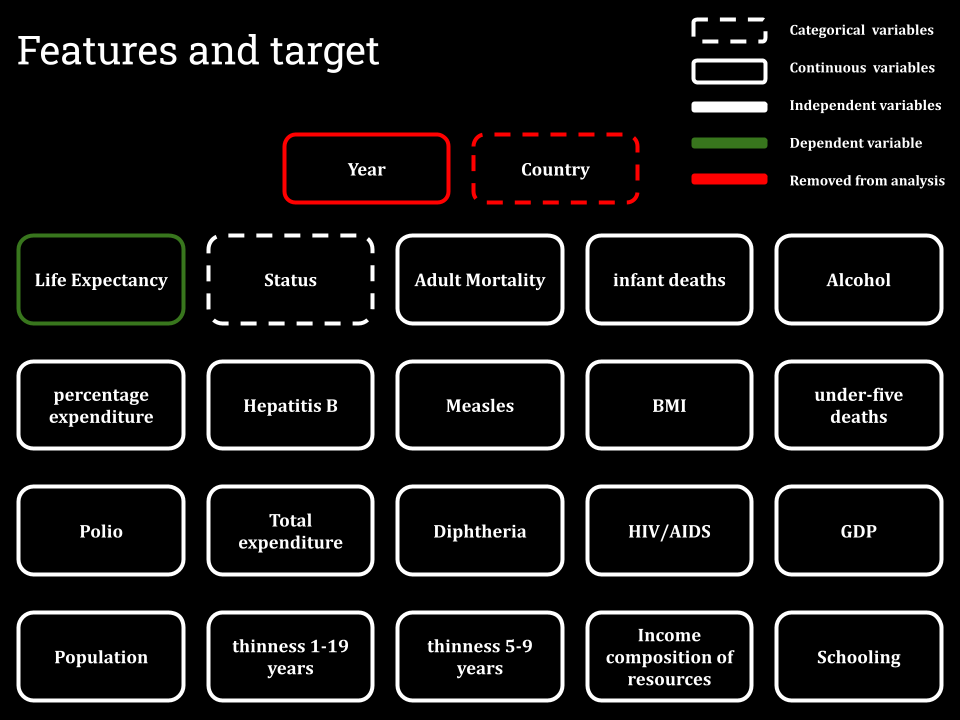

# Question of the analysis
****
The main question of this project is to figure out the main effective predictors of life expectancy. In a nutshell, we need to answer the question that **if a health organization wants to improve life expectancy somewhere, What variables can they change so that they reach their goal?**

# Approach
****
As **Life expectancy** is the **response variable** and it is **continuous**, we need to perform a **linear regression** to figure out what are the main predictors.
* We need to try different models based on different types of analysis so that we can determine which are the main predictors. and the models are:
 * Clean and filter data - (**Full Model**)
 * perform Exploratory Data Analysis - (**EDA Mode**l)
 * Apply Feature selection methods (**Feature selection model**)
 
 The following figure represents the analysis workflow:
 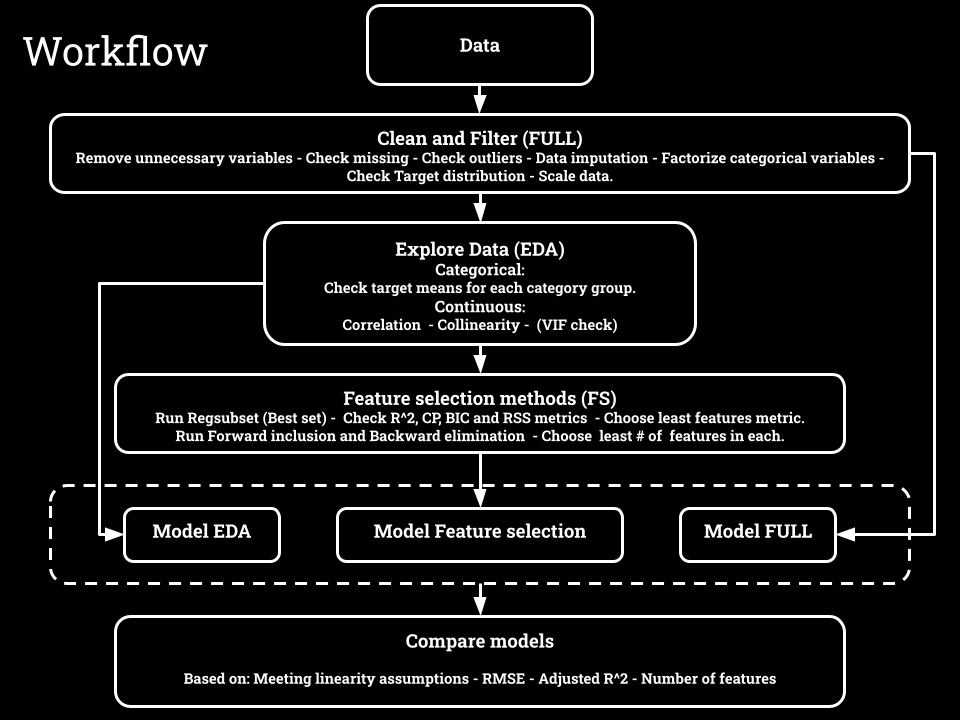

## Setup:

In [7]:
library(tidyverse)
library(ggplot2)
library(ggcorrplot)
library(corrplot)
library(leaps)
library(car)
library(Metrics)
library(reshape2)
library(ggpubr)
library(moments)

In [8]:
## plotting options
set_plot_dimensions <- function(width_choice , height_choice) {
options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

# 1. Load data
***

In [9]:
data <- read.csv("../input/life-expectancy-who/Life Expectancy Data.csv")
head(data)
sprintf("Dataset size: [%s]", toString(dim(data)))

 * As we can see, all features are continuous variables apart from **"Country"** and **"Status"** which are a **categorical variables**.

# 2. Clean and filter data.
***

## 2.1 Remove unnecessary variables

- **Year** and **Country** are removed as they are not relevant for the main question of the analysis. We need to know what are the main predictors of the life expectancy regardless where or when.

In [10]:
data <- subset(data, select = -c(Country, Year))

## 2.2 Missing data

In [11]:

missing.rows = dim(data)[1] -  dim(na.omit(data))[1]
sprintf("Dataset size: [%s]", toString(dim(data)))
sprintf("Missing rows: %s (%s%%)", missing.rows, round((missing.rows*100)/dim(data)[1], 2))

missings_df <- data.frame(type=c("missing", "non-missing") ,count = c(missing.rows,  dim(na.omit(data))[1]))

set_plot_dimensions(16,4)
ggplot(missings_df, aes(fill=type, y="", x=count)) + 
    geom_bar(position="stack", stat="identity")+
    ggtitle("Missing vs Non-missing row counts") +
    xlab("Missing count") + ylab("") +
    theme(text = element_text(size = 18))+
    scale_fill_brewer(palette="Set1")

* As we can see, around **44% of the total data is missing**, We want to study the characteristics. The following plot shows  the amount of missing value per feature.

In [12]:
missing_counts <- data.frame(feature = factor(names(data)),
                    counts=sapply(data, function(x) sum(is.na(x))))

set_plot_dimensions(16,8)
ggplot(missing_counts,
       aes(x=reorder(feature, -counts), y=counts, fill=counts)) +
                                  geom_bar(stat="identity") +
                                  ggtitle("Missing counts in each feature") +
                                  xlab("Feature") + ylab("Missing count") +
                                  theme(axis.text.x=element_text(angle=20, hjust=1))+
                                  theme(text = element_text(size = 18))+
                                  scale_fill_continuous(trans = 'reverse')

- The most significant amount of missing values is recorded in **population**, **GDP**, **Hepatitis B**, followed by **Total expediture**, **Achohol**, **Income.composition.of.resources** and **Schooling**.
 
- As we have more than **40% of missing data**, we can apply data imputation as following:
- Checking outliers in each variable that contains missings using boxplots
- The variables with **high outliers** will apply imputation with **median**
- The variables with **low outliers** will apply imputation with **mean**.

In [13]:
set_plot_dimensions(20,10)
par(mfrow=c(2,7))
boxplot(data$Life.expectancy,
        ylab = "Life Expectancy",
        main = "Boxplot of Life Expectancy",
        col= "#FF6666",
        outcol="#FF6666")
boxplot(data$Adult.Mortality,
        ylab = "Adult Mortality",
        main = "Boxplot of Adult Mortality",
        col= "#FF6666",
        outcol="#FF6666")
boxplot(data$Alcohol,
        ylab = "Alcohol",
        main = "Boxplot of Alcohol",
        col= "#008080",
        outcol="#008080")
boxplot(data$Hepatitis.B,
        ylab = "Hepatitis B",
        main = "Boxplot of Hepatitis B",
        col= "#FF6666",
        outcol="#FF6666")
boxplot(data$BMI,
        ylab = "BMI",
        main = "Boxplot of BMI",
        col= "#008080",
        outcol="#008080")
boxplot(data$Polio,
        ylab = "Polio",
        main = "Boxplot of Polio",
        col= "#FF6666",
        outcol="#FF6666")
boxplot(data$Total.expenditure,
        ylab = "Total Expenditure",
        main = "Boxplot of Total Expenditure",
        col= "#FF6666",
        outcol="#FF6666")
boxplot(data$Diphtheria,
        ylab = "Diphteria",
        main = "Boxplot of Diphteria",
        col= "#FF6666",
        outcol="#FF6666")
boxplot(data$GDP,
        ylab = "GDP",
        main = "Boxplot of GDP",
        col= "#FF6666",
        outcol="#FF6666")
boxplot(data$Population,
        ylab = "Population",
        main = "Boxplot of Population",
        col= "#FF6666",
        outcol="#FF6666")
boxplot(data$thinness..1.19.years,
        ylab = "Thinness 1-19 years",
        main = "Boxplot of Thinness for 1-19 years old",
        col= "#FF6666",
        outcol="#FF6666")
boxplot(data$thinness.5.9.years,
        ylab = "Thinness 5-9 years",
        main = "Boxplot of Thinness for 5-9 years old",
        col= "#FF6666",
        outcol="#FF6666")
boxplot(data$Income.composition.of.resources,
        ylab = "Income Composition",
        main = "Boxplot of Income Composition",
        col= "#008080",
        outcol="#008080")
boxplot(data$Schooling,
        ylab = "Schooling",
        main = "Boxplot of Schooling",
        col= "#FF6666",
        outcol="#FF6666")

- The boxplots that show none or few outliers are: **Alcohol**, **BMI**, **Income.composition.of.resources**

### 2.2.1 Apply imputation

- Calculate median for the high outliers variables.

In [14]:
Life.expectancy_median <- median(data$Life.expectancy,  na.rm = TRUE)
Adult.Mortality_median <- median(data$Adult.Mortality,  na.rm = TRUE)
Hepatitis.B_median <- median(data$Hepatitis.B,  na.rm = TRUE)
Polio_median <- median(data$Polio,  na.rm = TRUE)
Diphtheria_median <- median(data$Diphtheria,  na.rm = TRUE)
Total.expenditure_median <- median(data$Total.expenditure,  na.rm = TRUE)
GDP_median <- median(data$GDP,  na.rm = TRUE)
Population_median <- median(data$Population,  na.rm = TRUE)
thinness..1.19.years_median <- median(data$thinness..1.19.years,  na.rm = TRUE)
thinness.5.9.years_median <- median(data$thinness.5.9.years,  na.rm = TRUE)
Schooling_median <- median(data$Schooling,  na.rm = TRUE)

- Calculate mean for the low or none outliers variables.

In [15]:
Alcohol_mean <- mean(data$Alcohol,  na.rm = TRUE)
BMI_mean <- mean(data$BMI,  na.rm = TRUE)
Income.composition.of.resources_mean <- mean(data$Income.composition.of.resources,  na.rm = TRUE)

- Now, we replace the NAs with mean and median values respectively.

In [16]:
#medians
data$Life.expectancy[is.na(data$Life.expectancy)] <- Life.expectancy_median
data$Adult.Mortality[is.na(data$Adult.Mortality)] <- Adult.Mortality_median
data$Hepatitis.B[is.na(data$Hepatitis.B)] <- Hepatitis.B_median
data$Polio[is.na(data$Polio)] <- Polio_median
data$Diphtheria[is.na(data$Diphtheria)] <- Diphtheria_median
data$Total.expenditure[is.na(data$Total.expenditure)] <- Total.expenditure_median
data$GDP[is.na(data$GDP)] <- GDP_median
data$Population[is.na(data$Population)] <- Population_median
data$thinness..1.19.years[is.na(data$thinness..1.19.years)] <- thinness..1.19.years_median
data$thinness.5.9.years[is.na(data$thinness.5.9.years)] <- thinness.5.9.years_median
data$Schooling[is.na(data$Schooling)] <- Schooling_median
#means
data$Alcohol[is.na(data$Alcohol)] <- Alcohol_mean
data$BMI[is.na(data$BMI)] <- BMI_mean
data$Income.composition.of.resources[is.na(data$Income.composition.of.resources)] <- Income.composition.of.resources_mean

## 2.3 Factorize categorical variables

In [17]:
data$Status <- as.factor(data$Status)

## 2.3 Data transformation

* I will copy the data for now because it's needed unscaled for the categorical EDA part.

In [18]:
copy_data<- data


* First we need to check the denisty of the response.

In [19]:
set_plot_dimensions(10,8)
ggplot(data, aes(x=Life.expectancy)) + 
    geom_density(alpha=.3, fill="red", color="red", size=1.5)+
    geom_vline(aes(xintercept=mean(Life.expectancy)), size=1)+
    ggtitle("Distribution density of Life.expectancy") +
    theme(text = element_text(size = 18))
    
sprintf("Skewness: [%s]", toString(skewness(data$Life.expectancy, na.rm = TRUE)))


* we can notice that the target variable **Life.expectancy** is a little **left-skewed**.
* we can perform a **square root transformation on Life.expectancy**.
* Yet, we can make sure that it doesn't affect the multi-linear regression model by **checking the linearity assumptions** after we run our model.

In [20]:
data$Life.expectancy <- sqrt(max(data$Life.expectancy+1)- data$Life.expectancy)
data$Life.expectancy<- scale(data$Life.expectancy, scale=TRUE, center = TRUE)
ggplot(data, aes(x=Life.expectancy)) +
    geom_density(alpha=.3, fill="red", color="red", size=1.5)+
    geom_vline(aes(xintercept=mean(Life.expectancy)))+
    ggtitle("Distribution density of Life.expectancy") +
    theme(text = element_text(size = 18))

sprintf("Skewness: [%s]", toString(skewness(data$Life.expectancy, na.rm = TRUE)))

* Skewness improved a bit to the other side.
* **Life.expectancy** is already scaled too.

Lastly, we apply **scaling** to the continuous variables which standardizes every feature over a normal distribution so that we can include them in the models.

In [21]:
data <- as.data.frame(scale(subset(data,select = -c(Status)), scale=TRUE, center = TRUE))
data$Status <- copy_data$Status
# data$Life.expectancy <- copy_data$Life.expectancy

* Finally, we save this version of data in **data_FULL** where it will be used data frame for **Model_FULL** later.

In [22]:
data_FULL <- data

# 3. Exploratory Data Analysis (EDA)
***

## 3.1 Categorical variables:


- We need to check the boxplots of **life expectancy** over the two categories **developed** and **developing** to have an insight of their relation.

In [23]:
set_plot_dimensions(10,8)
ggplot(copy_data ,aes(x= Status,y=Life.expectancy, fill= Status)) + 
        geom_boxplot() +
        ggtitle("Life expectancy per country Status")+
        theme(text = element_text(size = 18))+
        scale_fill_brewer(palette="Set1")

- We can see that the **life expectancy** in **Developed** countries is **higher** which means the categorical variable might be a **good predictor** for the model.

## 3.2 Continuous variables:


 * First, Just by reading the dataset variables' names and description, we can have a very naive expectations of how they may perform as predictors. Yet, these assumptions are not true until proven by the statistical analysis. 

* The following figure shall explain my observations in that scope.

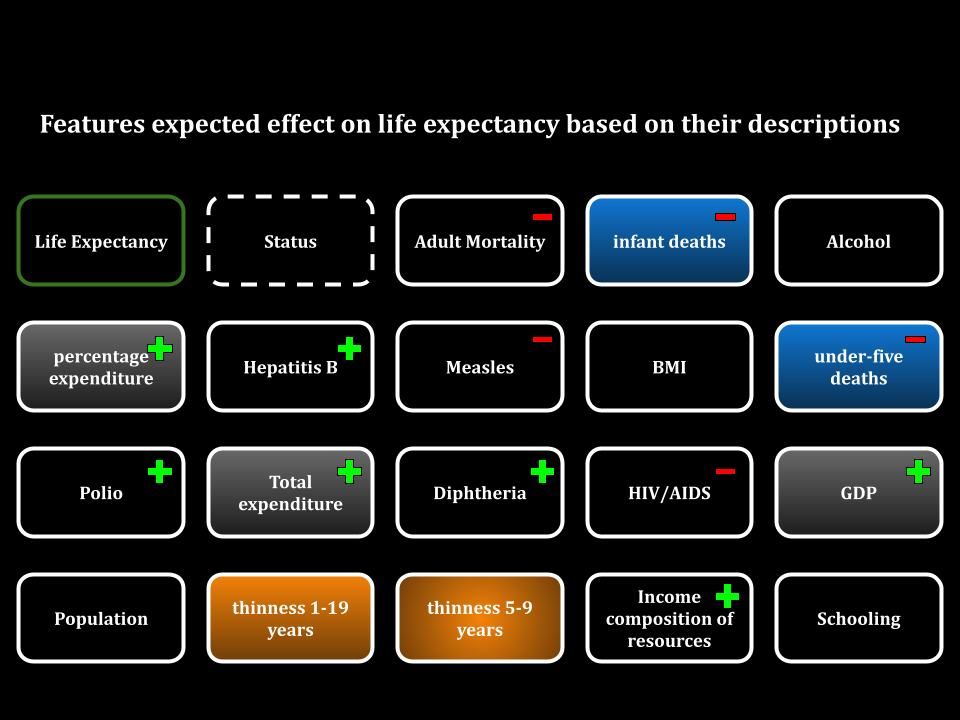

* **Green plus** means I expect these features to affect life expectancy **Positively** as they positive health behaviours(disease immunization) or high economic traits.
* **Red minus** means I expect these features to affect life expectancy **Negatively** as they indicate number of deaths.
* I can expect high correlation and high chance of collinearity in these 3 sets:
    * **infant deaths** & **under-five deaths** : By description, one includes the other.
    * **thinness 1-19 years** & **thinness 5-9 years**: Same as the first set.
    * **GDP** & **percentage expenditure** & **Total expenditure**: The 3 features indicate the economic state of a specific country. 

***Yet, these are all naive observations. We need to find evidence for that statistically.***

### 3.2.1 Correlation and collinearity
* We need to check the **correlation** between **features** and **target** so that it gives us a sense of which features can be a **good predictor** for the model. Moreover, the **correlation** between **featurs** and **themselves** can show a possibility of **collinearity** which we want to avoid in our model.

To do that we will check the **correlation matrix**

In [24]:
set_plot_dimensions(16,10)
corr <- round(cor(subset(data, select =-c(Status))), 3)
ggcorrplot(corr,type = "upper", lab = TRUE, outline.color = "black", lab_size = 4, legend.title = "Correlation")+
ggtitle("Correlation Matrix")



As expected, can notice very strong correlation**[>= 0.9]** between:

* **infant.deaths** and **under.five.deaths**.
* **GDP** and **percentage.expenditure**.
* **thinness..1.19.years** and **thinness.5.9.years**.

Yet, **correlation doesn't imply collinearity** between independent variables. Thus, check the **Variance Inflation Factor (VIF)** for the suspected variables in **a linear model**. Thereafter, eliminate one of the pairs with high VIF.

We consider VIF values larger than **5** as problematic.[ref]

In [25]:
mod.linear <- lm(Life.expectancy~ ., data = subset(data, select =-c(Status)))
vifs <- data.frame(vif(mod.linear))

set_plot_dimensions(16,8)
ggplot(vifs, aes(y=vif.mod.linear., x=row.names(vifs))) + 
    geom_bar(aes(fill=vif.mod.linear.>5),stat="identity")+
    scale_y_continuous(trans = "sqrt",  breaks = c(5, 10, 50, 100))+
    geom_hline(yintercept = 5, colour = "red") + 
    ggtitle("VIF per feature") +
    xlab("Featurs") + ylab("VIF") +
    theme(axis.text.x=element_text(angle=20, hjust=1))+
    theme(text = element_text(size = 18))+
    scale_fill_brewer(palette="Dark2")

As suspected, **the 3 correlated pairs** show **high VIFs**. So, we will omit one of each pair based on value of VIF then we check VIFs again.

* Features **infant.deaths** and **under.five.deaths** have abnormal VIFs way larger than 5, indicating a **strong collinearity**. We thus need to eliminate one of the two. So, we'll choose to **omit infant.deaths** as it has a higher VIF.
* We hence **omit** **GDP** as it has a higher VIF.

* Then we **omit** **thinness..1.19.years** as it has a higher VIF.

We save the new version of data after droping the 3 features in **data_EDA** where it will be used data frame for **Model_EDA** later 

In [26]:
data_EDA <- subset(data, select = -c(infant.deaths))
data_EDA <- subset(data_EDA, select = -c(GDP))
data_EDA <- subset(data_EDA, select = -c(thinness..1.19.years))

*  Now we can check the new **correlation matrix** and **VIF** barplot **after the eliminations**

In [27]:
set_plot_dimensions(16,10)
corr <- round(cor(subset(data_EDA, select =-c(Status))), 3)
ggcorrplot(corr,type = "upper", lab = TRUE, outline.color = "black", lab_size = 4, legend.title = "Correlation")

* The correlation matrix now shows no suspicious coeffecients that might indicate collinearity between the features.

Now, let's check VIFs again.

In [28]:
mod.linear <- lm(Life.expectancy~ ., data = subset(data_EDA, select =-c(Status)))
vifs <- data.frame(vif(mod.linear))

set_plot_dimensions(16,8)
ggplot(vifs, aes(y=vif.mod.linear., x=row.names(vifs))) + 
    geom_bar(aes(fill=vif.mod.linear.<5),stat="identity")+
    scale_y_continuous(trans = "sqrt",  breaks = c(5, 10, 50, 100))+
    geom_hline(yintercept = 5, colour = "red") + 
    ggtitle("VIF per feature") +
    xlab("Featurs") + ylab("VIF") +
    theme(axis.text.x=element_text(angle=20, hjust=1))+
    theme(text = element_text(size = 18))+
    scale_fill_brewer(palette="Dark2")

 - We can notice that VIFs are within an acceptable range and they are below 5.

Now, we have the **data_EDA** ready for the **Model_EDA**.

# 4. Feature selection methods
***


Feature selection is the process by which a subset of relevant features, or variables, are selected from a larger data set for constructing models. We will use 3 regression subset methods to come up with the most relevant subset of features namely:

* **Best subset**
* **Forward inclusion**
* **backward elimination**


By checking the method summary, we can decide the metric we would consider to find the best subset of variables. The 4 metrics are:

* **Residual sum of squares (rss)**
* **Adjusted R^2 (adjr2)**
* **Mallow's Cp (cp)**
* **Bayesian information criterion (bic)**




## 4.1 Best subset

In [29]:
regfit.best <- regsubsets(Life.expectancy~., data= data_EDA, nvmax = 16)
reg.summary <- summary(regfit.best)

par(mfrow=c(2,2))

#- residual sum of squares:
plot(reg.summary$rss,xlab="Number of Variables",ylab="RSS",type="l")
which.min(reg.summary$rss)
points(16,reg.summary$rss[16], col="red",cex=2,pch=20)

# adjusted-R^2 with its largest value
plot(reg.summary$adjr2,xlab="Number of Variables",ylab="Adjusted Rsq",type="l")
which.max(reg.summary$adjr2)
points(15,reg.summary$adjr2[15], col="red",cex=2,pch=20)

# Mallow's Cp with its smallest value
plot(reg.summary$cp,xlab="Number of Variables",ylab="Cp",type='l')
which.min(reg.summary$cp)
points(13,reg.summary$cp[13],col="red",cex=2,pch=20)

# BIC with its smallest value
plot(reg.summary$bic,xlab="Number of Variables",ylab="BIC",type='l')
which.min(reg.summary$bic)
points(12,reg.summary$bic[12],col="red",cex=2,pch=20)

The different metrics suggested different number of variables as as best subsets
* **RSS: 16 variables**
* **adjr2: 15 variables**
* **Cp: 13 variables**
* **BIC: 12 variables**

Thus, we will go with **BIC** as the metric for choosing subsets as it results **minimum number of variables**.

## 4.2 Forward inclusion

In [30]:

par(mfrow=c(1,1))

regfit.fwd <- regsubsets(Life.expectancy~.,data=data_EDA,nvmax=16,method="forward")
fwd.summary <-summary(regfit.fwd)

# fwd.summary
set_plot_dimensions(8,6)
plot(fwd.summary$bic,xlab="Number of Variables",ylab="BIC",type='l')
which.min(fwd.summary$bic)
points(12,fwd.summary$bic[12],col="red",cex=2,pch=20)

* **Forward inclusion** with **BIC** metric also suggested **12** variables as best subset

## 4.3 Backward elimination

In [31]:

regfit.bwd <- regsubsets(Life.expectancy~.,data=data_EDA,nvmax=16,method="backward")
bwd.summary <- summary(regfit.bwd)

# fwd.summary
set_plot_dimensions(8,6)
plot(bwd.summary$bic,xlab="Number of Variables",ylab="BIC",type='l')
which.min(bwd.summary$bic)
points(12,bwd.summary$bic[12],col="red",cex=2,pch=20)

* **Backward elimination** with **BIC** metric also suggested **12** variables as best subset

Let's check what are the 12 variables in each method and what are their coeffecients.

In [32]:
v_names <- rownames(as.data.frame(coef(regfit.best,12)))
coefs<- data.frame(v_names)
coefs$best_coef_value<- coef(regfit.best,12)
coefs$fwd_coef_value <-  coef(regfit.fwd,12)
coefs$bwd_coef_value <-  coef(regfit.bwd,12)

set_plot_dimensions(18,4)
ggplot(coefs,
       aes(x=v_names, y=best_coef_value, fill=best_coef_value)) +
                                  geom_bar(stat="identity") +
                                  ggtitle("Features & coeffecients: [method Best]") +
                                  xlab("Feature") + ylab("Coef value") +
                                  theme(axis.text.x=element_text(angle=20, hjust=1))+
                                  theme(text = element_text(size = 18))

ggplot(coefs,
       aes(x=v_names, y=fwd_coef_value, fill=fwd_coef_value)) +
                                  geom_bar(stat="identity") +
                                  ggtitle("Features & coeffecients: [method Forward inclusion]") +
                                  xlab("Feature") + ylab("Coef value") +
                                  theme(axis.text.x=element_text(angle=20, hjust=1))+
                                  theme(text = element_text(size = 18))
ggplot(coefs,
       aes(x=v_names, y=bwd_coef_value, fill=bwd_coef_value)) +
                                  geom_bar(stat="identity") +
                                  ggtitle("Feature & coeffecients: [method Backward elimination]") +
                                  xlab("Feature") + ylab("Coef value") +
                                  theme(axis.text.x=element_text(angle=20, hjust=1))+
                                  theme(text = element_text(size = 18))

* Clearly, the 3 methods choose **the exact same 12 variables** as best subset and they certainly have the same coefficients.

Now, let's save them in a version **data_FS** for the feature selection model **Model_FS**

In [33]:
data_FS <- subset(data_EDA, select=c(Life.expectancy,Status, Adult.Mortality, percentage.expenditure,
                                     Hepatitis.B, Polio, BMI, thinness.5.9.years, Measles,
                                     Diphtheria,HIV.AIDS,Income.composition.of.resources,Schooling))

# 5. Models 
***

## 5.1 Model (Full)

* Running linear regression model over **data_FULL**

In [34]:
set_plot_dimensions(16,10)


In [35]:
set.seed(123)

sample <- sample(c(TRUE, FALSE), nrow(data_FULL), replace=TRUE, prob=c(0.70,0.30))
train <- data_FULL[sample, ]
x.test <-data_FULL[!sample, ]
y.test <- data_FULL[!sample, ]$Life.expectancy
model.full<- lm(Life.expectancy~., data = train)
summary(model.full)

* We can notice **not all variables are significant**.
* Checking **RMSE**, **Adjusted R^2** and **Linearity assumptions** for **mode.full**

In [36]:
pred <- predict(model.full, newdata=x.test)
rmse(pred,y.test)
summary(model.full)$adj.r.squared
par(mfrow=c(2,2))
plot(model.full)

**The linearity assumptions are met for the full model
**
We can notice that all linear regression assumptions are roughly met:

**- The Residuals vs Fitted plot**

There is **no pattern in the residual plot**. we can assume linear relationship between the predictors and the outcome variables. (**linearity assumption**)

**- The Scale-Location plot**

The **residuals are spread equally** across the ranges of predictors. (**homoscedasticity assumption**)

- **The Normal Q-Q plot**

All the **points spread along the reference line equally**, it’s good enough to assume that the data has the normality of the residuals.(**normality of the residuals assumption**)

- **The Residuals vs Leverage**

Any point in the 0.5 cook distance boundary are influential. However, there are **no influential points here**. (**linearity assumption**)



| Model                                          | Number of Variables |        RMSE |  Adj. R^2 |  Linearity assumptions |
|------------------------------------------------|:-------------------:|------------:|----------:|----------:|
| Full Model               |         19          |    **0.44629** | **0.7894** | All met |


## 5.1 Model (EDA)


In [37]:
set.seed(123)

sample <- sample(c(TRUE, FALSE), nrow(data_EDA), replace=TRUE, prob=c(0.70,0.30))
train <- data_EDA[sample, ]
x.test <-data_EDA[!sample, ]
y.test <- data_EDA[!sample, ]$Life.expectancy
model.EDA <- lm(Life.expectancy~., data = train)
summary(model.EDA)

* We can notice **not all variables are significant**.
* Checking **RMSE**, **Adjusted R^2** and **Linearity assumptions** for **mode.EDA**

In [38]:
pred <- predict(model.EDA, newdata=x.test)
rmse(pred,y.test)
summary(model.EDA)$adj.r.squared
par(mfrow=c(2,2))
plot(model.EDA)

* Again, all linearity assumptions are met for EDA model.

| Model                                          | Number of Variables |        RMSE |  Adj. R^2 | Linearity assumptions |
|------------------------------------------------|:-------------------:|------------:|----------:|----------:|
| EDA Model               |         16          |    0.45452 | 0.7842 | All met | 


## 5.2 Model (Feature selection)

In [39]:
set.seed(123)

sample <- sample(c(TRUE, FALSE), nrow(data_FS), replace=TRUE, prob=c(0.70,0.30))
train <- data_FS[sample, ]
x.test <-data_FS[!sample, ]
y.test <- data_FS[!sample, ]$Life.expectancy
model.FS <- lm(Life.expectancy~., data = train)
summary(model.FS)

* We can notice **all variables are significant**.
* Checking **RMSE**, **Adjusted R^2** and **Linearity assumptions** for **mode.FS**

In [40]:
pred <- predict(model.FS, newdata=x.test)
rmse(pred,y.test)
summary(model.FS)$adj.r.squared
par(mfrow=c(2,2))
plot(model.FS)

* Also, all linearity assumptions are met for Feature selection model.

| Model                                          | Number of Variables |        RMSE |  Adj. R^2 |Linearity assumptions |
|------------------------------------------------|:-------------------:|------------:|----------:|----------:|
| Feature selection Model               |         **12**          |    0.4551 | 0.7839| All Met |


# 6. Conclusion
***

- we compare all the models variations in terms of Number of variables, RMSE and adj and Linearity assumptions 

| Model                    | Number of Variables |        RMSE    |  Adj. R^2  |Linearity assumptions |
|--------------------------|:-------------------:|---------------:|-----------:|---------------------:|
| Full Model               |         19          |    **0.44629** | **0.7894** | All met |
| EDA Model                |         16          |    0.45452     | 0.7842     | All met | 
| **Feature selection Model** |         **12**      |    0.4551      | 0.7839     | All Met |


- **We can see how adjusted R squared and RMSE are very close, so we don't have much loss when removing those variables.**

- **We can conclude that the Feature selection Model provides good results given that it decreases the number of features.**

**Then we can say that the main factors that affect life expectancy are:**

- **Status**
- **Adult.Mortality**
- **percentage.expenditure**
- **Hepatitis.B**
- **Measles**
- **BMI**
- **thinness.5.9.years**
- **Polio**
- **Diphtheria**
- **HIV.AIDS**
- **Income.composition.of.resources**
- **Schooling**